# NPZD slab model

For the first model example I will need:
- Forcing input
- Forcing_fluxes:
    - mixing
    - sinking
- 4 components (single) N, P, Z, D
- Fluxes:
TODO: GO OVER THE equations! Base model structure in math!
    - Grazing - linked to all NPZD
    - PhytoplanktonGrowth
        - Light - Dependence
        - Nutrients - Dependence
        - Temp - Dependence
    - mortality
    - remineralisation
    - higher order pred, etc

In [1]:
import numpy as np
import xsimlab as xs

In [2]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra


from phydra.utility.xsimlabwrappers import phydra_setup

In [3]:
from phydra.processes.main import Grid0D, Boundary0D
from phydra.processes.components import Component, Time, make_Component
from phydra.processes.environments import BaseEnvironment, Slab
from phydra.processes.fluxes import Flux, LimitedGrowth
from phydra.processes.forcingfluxes import Mixing, Sinking, Upwelling, make_FX_flux
from phydra.processes.forcing import SinusoidalMLD, ConstantN0
from phydra.processes.gekkocontext import GekkoContext, GekkoSolve, InheritGekkoContext

In [4]:
from phydra.processes.forcing import NutrientForcing, MLDForcing

In [5]:
print('xarray-simlab version: ', xs.__version__)
print('phydra version: ', phydra.__version__)

xarray-simlab version:  0.4.1
phydra version:  0+untagged.72.g158ff9b.dirty


In [7]:
model = xs.Model({
    'time':Time, 'grid':Grid0D, 'ibcs':Boundary0D, 
    
    'context':GekkoContext,
                  
    'N':make_Component('Nutrient','N'), 'P':make_Component('Phytoplankton','P'),
    'Z':make_Component('Zooplankton','Z'), 'D':make_Component('Detritus','D'),
    'Env':Slab, 
    
    # Fluxes
    #'P_Growth':LimitedGrowth, 
    
    # ForcingFluxes
    'Sinking':make_FX_flux(Sinking, 'S'),
    'Upwelling':make_FX_flux(Upwelling, 'U'),
    
    'MLD':SinusoidalMLD, 
    'N0':ConstantN0, 
    
    'solver':GekkoSolve
})

model

Sinking_S
<class 'phydra.processes.forcingfluxes.Sinking'> S
Upwelling_U
<class 'phydra.processes.forcingfluxes.Upwelling'> U


<xsimlab.Model (14 processes, 17 inputs)>
context
time
    days            [in] ('time',) time in days
grid
    length          [in]
    shape           [in]
ibcs
    ibc             [in] Initial Boundary Conditions
N
    init            [in]
    dim             [in]
P
    init            [in]
    dim             [in]
Z
    dim             [in]
    init            [in]
D
    init            [in]
    dim             [in]
N0
    constant_N0     [in] value of the constant Nutrient forcing
MLD
Upwelling
    kappa           [in] constant mixing coefficient
    C_labels        [in] u label of component(s) that grows
Sinking
    C_labels        [in] s label of component(s) that grows
    kappa           [in] constant mixing coefficient
Env
solver

In [8]:
model.index_vars 


[('time', 'time'),
 ('N', 'N'),
 ('P', 'P'),
 ('Z', 'Z'),
 ('D', 'D'),
 ('Env', 'components'),
 ('Env', 'forcingfluxes'),
 ('Sinking', 'S'),
 ('Upwelling', 'U')]

In [24]:
in_ds = phydra_setup(
    model=model,
    input_vars={
        'time__days': ('time', np.arange(0, 365*3)), #365*
        
        'N':{'dim':1,'init':1}, 
        'P':{'dim':1,'init':1},
        'Z':{'dim':1,'init':1},
        'D':{'dim':1,'init':1},
        
        #'P_Growth':{'mu':1.,
        #       'C_label':'P',
        #       'R_label':'N',
        #       'halfsat':0.5},
        
        'Sinking':{'kappa':0.1,
               'C_labels':['D','P']},
        
        'Upwelling':{'kappa':0.1,
               'C_labels':['N']},
        
        'N0__constant_N0':2.
    },
    output_vars={
        'Env__comp_output':None,
        #'Env__fxflux_output':None,
    }
                 )

In [25]:
with model:
    out_ds = in_ds.xsimlab.run()

Initializing Gekko Context
Initializing Model Time
dimensions of component N are initialized at 1
Initializing component  N ['N']
FULLDIMS [[0.]]
[[1]]
dimensions of component P are initialized at 1
Initializing component  P ['P']
FULLDIMS [[0.]]
[[1]]
dimensions of component Z are initialized at 1
Initializing component  Z ['Z']
FULLDIMS [[0.]]
[[1]]
dimensions of component D are initialized at 1
Initializing component  D ['D']
FULLDIMS [[0.]]
[[1]]
forcing flux Upwelling is initialized at ['N']
['Upwelling-N']
Initializing forcing flux Upwelling for components ['N']
N initFXflux [[list([])]]
N initFXflux [[list([0])]]
forcing flux Sinking is initialized at ['D' 'P']
['Sinking-D', 'Sinking-P']
Initializing forcing flux Sinking for components ['D' 'P']
D initFXflux [[list([])]]
D initFXflux [[list([0])]]
P initFXflux [[list([])]]
P initFXflux [[list([0])]]
hello there


Initializing Environment: 
 components:['N', 'P', 'Z', 'D'] 
 fx-fluxes:['Upwelling-N', 'Sinking-D', 'Sinking-P']


A

In [26]:
out_ds

<xarray.Dataset>
Dimensions:              (D: 1, N: 1, P: 1, S: 2, U: 1, Z: 1, clock: 2, components: 4, forcingfluxes: 3, s: 2, time: 1095, u: 1)
Coordinates:
  * D                    (D) <U1 'D'
  * N                    (N) <U1 'N'
  * P                    (P) <U1 'P'
  * S                    (S) <U9 'Sinking-D' 'Sinking-P'
  * U                    (U) <U11 'Upwelling-N'
  * Z                    (Z) <U1 'Z'
  * clock                (clock) int64 0 1
  * components           (components) <U1 'N' 'P' 'Z' 'D'
  * forcingfluxes        (forcingfluxes) <U11 'Upwelling-N' ... 'Sinking-P'
  * time                 (time) int64 0 1 2 3 4 5 ... 1090 1091 1092 1093 1094
Dimensions without coordinates: s, u
Data variables:
    D__dim               int64 1
    D__init              int64 1
    Env__comp_output     (components, time) float64 1.0 1.008 ... 1.804e-13
    N0__constant_N0      float64 2.0
    N__dim               int64 1
    N__init              int64 1
    P__dim               int64 1
    P__init              int64 1
    Sinking__C_labels    (s) <U1 'D' 'P'
    Sinking__kappa       float64 0.1
    Upwelling__C_labels  (u) <U1 'N'
    Upwelling__kappa     float64 0.1
    Z__dim               int64 1
    Z__init              int64 1
    grid__length         int64 1
    grid__shape          int64 1
    ibcs__ibc            float64 nan
    time__days           (time) int64 0 1 2 3 4 5 ... 1090 1091 1092 1093 1094

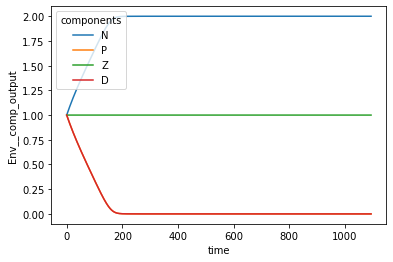

In [27]:
out_ds.Env__comp_output.plot.line(x='time')

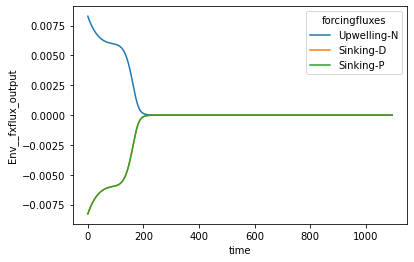

In [23]:
out_ds.Env__fxflux_output.plot.line(x='time')